In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/textAnalytics/

myBertModel.h5	myLSTMModel.h5	myXlnetModel.h5  train.csv  xlnet_model.h5
myBertModel.pt	myXlnetModel	test.csv	 valid.csv


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import re
from nltk.tokenize import word_tokenize
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Embedding
from keras.callbacks import EarlyStopping
from nltk.corpus import stopwords

In [ ]:
# Load the dataset
train_data = pd.read_csv('/content/drive/MyDrive/textAnalytics/train.csv')
val_data = pd.read_csv('/content/drive/MyDrive/textAnalytics/valid.csv')
test_data = pd.read_csv('/content/drive/MyDrive/textAnalytics/test.csv')

In [ ]:
# define a function to remove stopwords from a single tweet
def remove_stopwords(tweet):
    # tokenize the tweet into individual words
    words = word_tokenize(tweet)

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word.casefold() not in stop_words]

    # join the remaining words back into a single string
    filtered_tweet = ' '.join(filtered_words)

    return filtered_tweet

# apply the remove_stopwords function to the 'tweet' column of the DataFrame
train_data['tweet'] = train_data['tweet'].apply(remove_stopwords)
val_data['tweet'] = val_data['tweet'].apply(remove_stopwords)
test_data['tweet'] = test_data['tweet'].apply(remove_stopwords)

In [ ]:
# Clean the text data by removing URLs, mentions, and hashtags
train_data['tweet'] = train_data['tweet'].apply(lambda x: re.sub(r'http\S+', '', x))
train_data['tweet'] = train_data['tweet'].apply(lambda x: re.sub(r'@\S+', '', x))
train_data['tweet'] = train_data['tweet'].apply(lambda x: re.sub(r'#\S+', '', x))

val_data['tweet'] = val_data['tweet'].apply(lambda x: re.sub(r'http\S+', '', x))
val_data['tweet'] = val_data['tweet'].apply(lambda x: re.sub(r'@\S+', '', x))
val_data['tweet'] = val_data['tweet'].apply(lambda x: re.sub(r'#\S+', '', x))

test_data['tweet'] = test_data['tweet'].apply(lambda x: re.sub(r'http\S+', '', x))
test_data['tweet'] = test_data['tweet'].apply(lambda x: re.sub(r'@\S+', '', x))
test_data['tweet'] = test_data['tweet'].apply(lambda x: re.sub(r'#\S+', '', x))

# # Tokenize the text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_data['tweet'])

train_data['tweet'] = tokenizer.texts_to_sequences(train_data['tweet'])
val_data['tweet'] = tokenizer.texts_to_sequences(val_data['tweet'])
test_data['tweet'] = tokenizer.texts_to_sequences(test_data['tweet'])

# Pad the text sequences
maxlen = 100
train_data_tweet = pad_sequences(train_data['tweet'], padding='post', maxlen=maxlen)
val_data_tweet = pad_sequences(val_data['tweet'], padding='post', maxlen=maxlen)
test_data_tweet = pad_sequences(test_data['tweet'], padding='post', maxlen=maxlen)

In [ ]:
subset = ['25','50','75','100']

# Preprocessing the data
train_X = {}
train_y = {}

for i in subset:
  if i != '100':
    train_X[i], _, train_y[i], _ = train_test_split(train_data_tweet, train_data['label'].map({'NOT': 0, 'OFF': 1}), test_size=float(1-int(i)/100), random_state=42)

train_X['100'] = train_data_tweet
val_X = val_data_tweet
test_X = test_data_tweet

train_y['100'] = train_data['label'].map({'NOT': 0, 'OFF': 1})
val_y = val_data['label'].map({'NOT': 0, 'OFF': 1})
test_y = test_data['label'].map({'NOT': 0, 'OFF': 1})

In [ ]:
type(train_X['100'])
type(train_y['100'])
val_y

0      0
1      0
2      0
3      1
4      0
      ..
922    1
923    0
924    1
925    1
926    0
Name: label, Length: 927, dtype: int64

In [ ]:
# Build the model
models = {}

for i in subset:
  models[i] = Sequential()
  models[i].add(Embedding(10000, 100, input_length=maxlen))
  models[i].add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
  models[i].add(Dense(1, activation='sigmoid'))
  models[i].compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
np.shape(train_X['100'])
# np.shape(train_y['100'])

(12313, 100)

In [ ]:
history = {}
for i in subset[::-1]:
  # Train the model
  history[i] = models[i].fit(train_X[i], train_y[i], validation_data=(val_X, val_y), epochs=10, batch_size=32, callbacks=[early_stop])

Epoch 1/10
385/385 [==============================] - 161s 397ms/step - loss: 0.6304 - accuracy: 0.6749 - val_loss: 0.5789 - val_accuracy: 0.7273
Epoch 2/10
385/385 [==============================] - 150s 389ms/step - loss: 0.5232 - accuracy: 0.7583 - val_loss: 0.5266 - val_accuracy: 0.7487
Epoch 3/10
385/385 [==============================] - 151s 393ms/step - loss: 0.5071 - accuracy: 0.7645 - val_loss: 0.5537 - val_accuracy: 0.7536
Epoch 4/10
385/385 [==============================] - 158s 409ms/step - loss: 0.5071 - accuracy: 0.7696 - val_loss: 0.6314 - val_accuracy: 0.6773
Epoch 5/10
385/385 [==============================] - 150s 389ms/step - loss: 0.5512 - accuracy: 0.7255 - val_loss: 0.5852 - val_accuracy: 0.7339
Epoch 1/10
289/289 [==============================] - 120s 394ms/step - loss: 0.6379 - accuracy: 0.6659 - val_loss: 0.6310 - val_accuracy: 0.6699
Epoch 2/10
289/289 [==============================] - 111s 385ms/step - loss: 0.5425 - accuracy: 0.7561 - val_loss: 0.5750 -

In [ ]:
import json

history_dict = {}
for i in subset:

  history_dict[i] = {}

  # Get the training accuracy
  history_dict[i]['accuracy'] = history[i].history['accuracy']

  # Get the validation accuracy
  history_dict[i]['val_accuracy'] = history[i].history['val_accuracy']

  # Get the training loss
  history_dict[i]['loss'] = history[i].history['loss']

  # Get the validation loss
  history_dict[i]['val_loss'] = history[i].history['val_loss']


with open('/content/drive/MyDrive/textAnalytics/history_dict_lstm.json', 'w') as f:
    f.write(json.dumps(history_dict))

In [ ]:
# Evaluate the model
# test_data = pd.read_csv('testset-levela.tsv', delimiter='\t', header=0)
# test_data = test_data[['tweet']]
# test_data = test_data.values
# test_data = tokenizer.texts_to_sequences(test_data)
# test_data = pad_sequences(test_data, padding='post', maxlen=maxlen)
# predictions = model.predict_classes(test_data)


In [ ]:
for i in subset:
  models[i].save('/content/drive/MyDrive/textAnalytics/myLSTMModel_'+i+'.h5')

In [ ]:
from keras.models import load_model

# load the saved model
loaded_model = load_model('/content/drive/MyDrive/textAnalytics/myLSTMModel_'+i+'.h5')

In [ ]:
loss_saved = {}
accuracy_saved = {}

for i in subset:
  loss_saved[i], accuracy_saved[i] = models[i].evaluate(test_X, test_y)

  print(f"Test Loss: {loss_saved[i]:.4f}")
  print(f"Test Accuracy: {accuracy_saved[i]:.4f}")

with open('/content/drive/MyDrive/textAnalytics/test_loss_lstm.json', 'w') as f:
    f.write(json.dumps(loss_saved))

with open('/content/drive/MyDrive/textAnalytics/test_accuracy_lstm.json', 'w') as f:
    f.write(json.dumps(accuracy_saved))

27/27 [==============================] - 2s 82ms/step - loss: 0.6771 - accuracy: 0.7560
Test Loss: 0.6771
Test Accuracy: 0.7560
27/27 [==============================] - 1s 52ms/step - loss: 0.6008 - accuracy: 0.7457
Test Loss: 0.6008
Test Accuracy: 0.7457
27/27 [==============================] - 1s 54ms/step - loss: 0.6287 - accuracy: 0.7443
Test Loss: 0.6287
Test Accuracy: 0.7443
27/27 [==============================] - 1s 46ms/step - loss: 0.5904 - accuracy: 0.7243
Test Loss: 0.5904
Test Accuracy: 0.7243


In [ ]:
history_dict['25']['val_accuracy']

[0.6677454113960266,
 0.669061541557312,
 0.6870443224906921,
 0.7127724289894104,
 0.6863646507263184,
 0.7267637252807617]

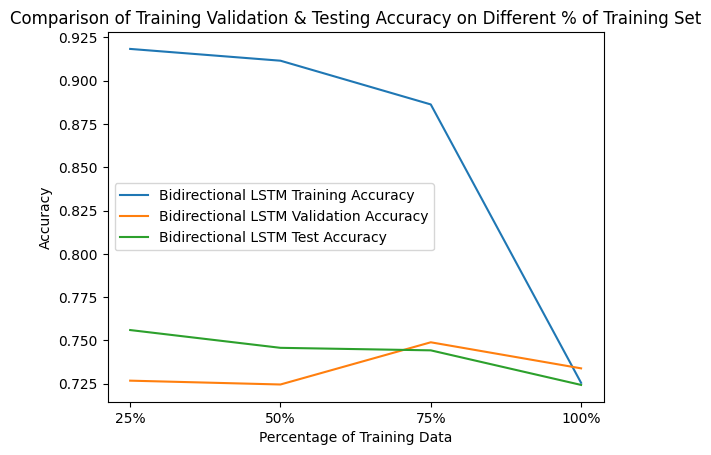

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Get the training accuracy history of the first model
model_train_acc =  [history_dict['25']['accuracy'][-1],history_dict['50']['accuracy'][-1],history_dict['75']['accuracy'][-1],history_dict['100']['accuracy'][-1],]

# Get the validation accuracy history of the first model
model_val_acc = [history_dict['25']['val_accuracy'][-1],history_dict['50']['val_accuracy'][-1],history_dict['75']['val_accuracy'][-1],history_dict['100']['val_accuracy'][-1],]

# Get the training accuracy history of the second model
model_test_acc = [accuracy_saved['25'],accuracy_saved['50'],accuracy_saved['75'],accuracy_saved['100']]


# Create the plot
plt.plot(model_train_acc, label='Bidirectional LSTM Training Accuracy')
plt.plot(model_val_acc, label='Bidirectional LSTM Validation Accuracy')
plt.plot(model_test_acc, label='Bidirectional LSTM Test Accuracy')
plt.legend()
plt.xticks([0, 1, 2, 3], ['25%', '50%', '75%', '100%'])
plt.xlabel('Percentage of Training Data')
plt.ylabel('Accuracy')
plt.title('Comparison of Training Validation & Testing Accuracy on Different % of Training Set')
plt.show()
plt.savefig('/content/drive/MyDrive/textAnalytics/lstm_comparing_val_accuracy.png')
